In [1]:
# Notebook 4 - XGBoost Optimizado
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# FUNCIONES AUXILIARES
def reduce_memory_usage(df, verbose=True):
    """Reduce el uso de memoria optimizando tipos de datos"""
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif col_type == object:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'Memoria reducida de {start_mem:.2f} MB a {end_mem:.2f} MB '
              f'({100 * (start_mem - end_mem) / start_mem:.1f}% reducción)')
    return df

def section_header(title):
    print(f"\n{'='*60}")
    print(f"{title}")
    print('='*60)


CARGA Y OPTIMIZACIÓN DE DATOS
Datos cargados: Train (692500, 21), Test (296786, 20)
Memoria reducida de 724.28 MB a 25.24 MB (96.5% reducción)
Memoria reducida de 292.18 MB a 10.61 MB (96.4% reducción)

Verificando variable objetivo...
Valores únicos en objetivo: ['medio-alto', 'bajo', 'alto', 'medio-bajo']
Categories (4, object): ['alto', 'bajo', 'medio-alto', 'medio-bajo']
Conteo por clase ANTES de limpieza:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64
Filas después de limpiar nulos en objetivo: 692500

Distribución objetivo DESPUÉS de limpieza:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64


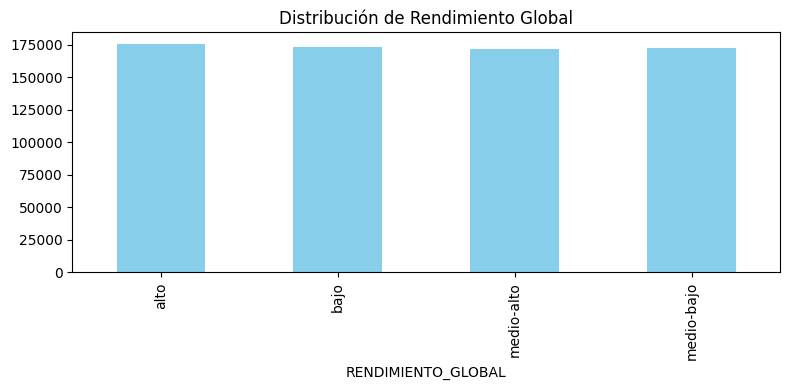

In [3]:
# CARGA Y OPTIMIZACIÓN INICIAL DE DATOS
section_header("CARGA Y OPTIMIZACIÓN DE DATOS")

try:
    df_train = pd.read_csv('/content/train.csv')
    df_test = pd.read_csv('/content/test.csv')
    print(f"Datos cargados: Train {df_train.shape}, Test {df_test.shape}")

    df_train = reduce_memory_usage(df_train)
    df_test = reduce_memory_usage(df_test)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Identificar columnas
target_column = 'RENDIMIENTO_GLOBAL'
id_column = 'ID'

# Verificar y limpiar la variable objetivo antes del análisis
print(f"\nVerificando variable objetivo...")
print(f"Valores únicos en objetivo: {df_train[target_column].unique()}")
print(f"Conteo por clase ANTES de limpieza:")
target_dist_before = df_train[target_column].value_counts().sort_index()
print(target_dist_before)

# Limpiar valores problemáticos si existen
df_train = df_train.dropna(subset=[target_column])  # Eliminar nulos en objetivo
print(f"Filas después de limpiar nulos en objetivo: {len(df_train)}")

# Verificar distribución después de limpieza
print(f"\nDistribución objetivo DESPUÉS de limpieza:")
target_dist = df_train[target_column].value_counts().sort_index()
print(target_dist)

# Visualización simple
plt.figure(figsize=(8, 4))
target_dist.plot(kind='bar', color='skyblue')
plt.title('Distribución de Rendimiento Global')
plt.tight_layout()
plt.show()
plt.close()

In [4]:
# IDENTIFICACIÓN DE TIPOS DE COLUMNAS
section_header("ANÁLISIS DE CARACTERÍSTICAS")

cat_columns = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_columns = df_train.select_dtypes(include=['number']).columns.tolist()

cat_columns = [col for col in cat_columns if col not in [target_column, id_column]]
num_columns = [col for col in num_columns if col not in [target_column, id_column]]

print(f"Categóricas: {len(cat_columns)}")
print(f"Numéricas: {len(num_columns)}")

missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()
print(f"\nColumnas con valores nulos (train): {(missing_train > 0).sum()}")
print(f"Columnas con valores nulos (test): {(missing_test > 0).sum()}")


ANÁLISIS DE CARACTERÍSTICAS
Categóricas: 14
Numéricas: 5

Columnas con valores nulos (train): 11
Columnas con valores nulos (test): 11


In [5]:
# INGENIERÍA DE CARACTERÍSTICAS LIGERA
section_header("INGENIERÍA DE CARACTERÍSTICAS OPTIMIZADA")

def lightweight_feature_engineering(df_train, df_test):
    """Ingeniería de características que no duplica DataFrames"""
    if len(num_columns) > 2:
        numeric_cols = [col for col in num_columns if col in df_train.columns][:10]
        df_train['num_mean'] = df_train[numeric_cols].mean(axis=1, skipna=True).astype(np.float32)
        df_test['num_mean'] = df_test[numeric_cols].mean(axis=1, skipna=True).astype(np.float32)
        df_train['num_std'] = df_train[numeric_cols].std(axis=1, skipna=True).astype(np.float32)
        df_test['num_std'] = df_test[numeric_cols].std(axis=1, skipna=True).astype(np.float32)
        print("Características estadísticas básicas creadas")

    for col in cat_columns[:5]:
        if col in df_train.columns:
            unique_count = df_train[col].nunique()
            if unique_count < 50:
                train_values = df_train[col].astype(str)
                test_values = df_test[col].astype(str)
                freq_map = train_values.value_counts().to_dict()
                df_train[f'{col}_freq'] = train_values.map(freq_map).fillna(0).astype(np.int16)
                df_test[f'{col}_freq'] = test_values.map(freq_map).fillna(0).astype(np.int16)

    print("Características de frecuencia creadas")
    return df_train, df_test

df_train, df_test = lightweight_feature_engineering(df_train, df_test)
gc.collect()


INGENIERÍA DE CARACTERÍSTICAS OPTIMIZADA
Características estadísticas básicas creadas
Características de frecuencia creadas


3344

In [6]:
# PREPROCESAMIENTO OPTIMIZADO
section_header("PREPROCESAMIENTO OPTIMIZADO")

def optimized_preprocessing(df_train, df_test):
    """Preprocesamiento que minimiza copias de datos"""
    all_numeric = df_train.select_dtypes(include=['number']).columns.tolist()
    all_categorical = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

    feature_numeric = [col for col in all_numeric if col not in [target_column, id_column]]
    feature_categorical = [col for col in all_categorical if col not in [target_column, id_column]]

    print(f"Procesando {len(feature_numeric)} numéricas, {len(feature_categorical)} categóricas")

    if len(feature_numeric) > 0:
        imputer = SimpleImputer(strategy='median')
        df_train[feature_numeric] = imputer.fit_transform(df_train[feature_numeric])
        df_test[feature_numeric] = imputer.transform(df_test[feature_numeric])

        scaler = RobustScaler()
        df_train[feature_numeric] = scaler.fit_transform(df_train[feature_numeric])
        df_test[feature_numeric] = scaler.transform(df_test[feature_numeric])
        print("Preprocesamiento numérico completado")

    if len(feature_categorical) > 0:
        for col in feature_categorical:
            df_train[col] = df_train[col].astype(str)
            df_test[col] = df_test[col].astype(str)
            mode_val = df_train[col].mode()[0] if len(df_train[col].mode()) > 0 else 'missing'
            df_train[col].fillna(mode_val, inplace=True)
            df_test[col].fillna(mode_val, inplace=True)

        categorical_to_process = []
        for col in feature_categorical[:10]:
            if df_train[col].nunique() < 20:
                categorical_to_process.append(col)

        if categorical_to_process:
            df_train_dummies = pd.get_dummies(df_train[categorical_to_process],
                                            drop_first=True, dtype=np.int8)
            df_test_dummies = pd.get_dummies(df_test[categorical_to_process],
                                           drop_first=True, dtype=np.int8)

            all_dummy_cols = set(df_train_dummies.columns) | set(df_test_dummies.columns)
            for col in all_dummy_cols:
                if col not in df_train_dummies.columns:
                    df_train_dummies[col] = 0
                if col not in df_test_dummies.columns:
                    df_test_dummies[col] = 0

            df_train_dummies = df_train_dummies.reindex(sorted(df_train_dummies.columns), axis=1)
            df_test_dummies = df_test_dummies.reindex(sorted(df_test_dummies.columns), axis=1)

            df_train = pd.concat([df_train, df_train_dummies], axis=1)
            df_test = pd.concat([df_test, df_test_dummies], axis=1)

            df_train.drop(categorical_to_process, axis=1, inplace=True)
            df_test.drop(categorical_to_process, axis=1, inplace=True)

        print("Preprocesamiento categórico completado")

    return df_train, df_test

df_train, df_test = optimized_preprocessing(df_train, df_test)


PREPROCESAMIENTO OPTIMIZADO
Procesando 11 numéricas, 14 categóricas
Preprocesamiento numérico completado
Preprocesamiento categórico completado


In [7]:
# CORRECCIÓN: Mejorar la conversión de columnas categóricas restantes
print("Convirtiendo columnas categóricas restantes...")
for col in df_train.columns:
    if df_train[col].dtype == 'category' or df_train[col].dtype == 'object':
        if col not in [target_column, id_column]:
            le = LabelEncoder()
            train_values = df_train[col].astype(str).fillna('MISSING')
            test_values = df_test[col].astype(str).fillna('MISSING')

            le.fit(train_values)
            df_train[col] = le.transform(train_values)

            unknown_mask = ~test_values.isin(le.classes_)
            if unknown_mask.sum() > 0:
                print(f"{col}: {unknown_mask.sum()} valores desconocidos encontrados")
                most_frequent = train_values.mode()[0] if len(train_values.mode()) > 0 else 'MISSING'
                test_values_clean = test_values.copy()
                test_values_clean[unknown_mask] = most_frequent
                df_test[col] = le.transform(test_values_clean)
            else:
                df_test[col] = le.transform(test_values)

df_train = reduce_memory_usage(df_train, verbose=False)
df_test = reduce_memory_usage(df_test, verbose=False)
gc.collect()
print(f"Dimensiones finales: Train {df_train.shape}, Test {df_test.shape}")

Convirtiendo columnas categóricas restantes...
    ⚠️  ESTU_PRGM_ACADEMICO: 10 valores desconocidos encontrados
Dimensiones finales: Train (692500, 58), Test (296786, 57)


In [8]:
# SELECCIÓN DE CARACTERÍSTICAS EFICIENTE
section_header("SELECCIÓN DE CARACTERÍSTICAS")

feature_cols = [col for col in df_train.columns if col not in [target_column, id_column]]
X = df_train[feature_cols]
y = df_train[target_column]

# Verificar la variable objetivo antes de codificar
print(f"Verificando variable objetivo antes de codificar...")
print(f"Clases únicas: {y.unique()}")
print(f"Conteo por clase:")
print(y.value_counts().sort_index())

# Codificar objetivo con verificación
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Verificar después de la codificación
print(f"\nDespués de codificación:")
print(f"Clases codificadas: {np.unique(y_encoded)}")
unique_counts = np.bincount(y_encoded)
print(f"Conteo por clase codificada: {unique_counts}")

# Verificar que todas las clases tengan al menos 2 muestras
min_samples = np.min(unique_counts)
print(f"Mínimo de muestras por clase: {min_samples}")

if min_samples < 2:
    print("ERROR: Una clase tiene menos de 2 muestras")
    print("Aplicando corrección...")
    # Si hay una clase con muy pocas muestras, la combinamos con otra similar
    # o la eliminamos (esto depende del contexto específico)
    # Por ahora, mostraremos el problema y continuaremos sin stratify
    use_stratify = False
else:
    print("Todas las clases tienen suficientes muestras")
    use_stratify = True

print(f"Características disponibles: {X.shape[1]}")

max_features = min(30, X.shape[1])
selector = SelectKBest(score_func=f_classif, k=max_features)
X_selected = selector.fit_transform(X, y_encoded)

selected_features = X.columns[selector.get_support()].tolist()
print(f"Características seleccionadas: {len(selected_features)}")

feature_scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("\nTOP 10 CARACTERÍSTICAS:")
for i, (_, row) in enumerate(feature_scores.head(10).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['score']:.2f}")

del X, feature_scores
gc.collect()


SELECCIÓN DE CARACTERÍSTICAS
Verificando variable objetivo antes de codificar...
Clases únicas: ['medio-alto', 'bajo', 'alto', 'medio-bajo']
Categories (4, object): ['alto', 'bajo', 'medio-alto', 'medio-bajo']
Conteo por clase:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64

Después de codificación:
Clases codificadas: [0 1 2 3]
Conteo por clase codificada: [175619 172987 171619 172275]
Mínimo de muestras por clase: 171619
Todas las clases tienen suficientes muestras
Características disponibles: 56
Características seleccionadas: 30

TOP 10 CARACTERÍSTICAS:
  1. ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones: 23390.81
  2. coef_1: 15662.15
  3. coef_2: 9154.67
  4. ESTU_PAGOMATRICULAPROPIO: 8155.15
  5. FAMI_EDUCACIONPADRE_Postgrado: 7533.02
  6. FAMI_TIENEAUTOMOVIL_Si: 6719.42
  7. FAMI_ESTRATOVIVIENDA_freq: 5642.63
  8. FAMI_EDUCACIONPADRE_Primaria incompleta: 5148.24
  9. FAMI_ESTRATOVIVIENDA_Estrato

0

In [9]:
# MODELADO XGBOOST OPTIMIZADO
section_header("MODELADO XGBOOST")

X_final = df_train[selected_features]

# CORRECCIÓN: Usar stratify solo si es posible
if use_stratify:
    X_train, X_val, y_train, y_val = train_test_split(
        X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print("División estratificada aplicada")
else:
    X_train, X_val, y_train, y_val = train_test_split(
        X_final, y_encoded, test_size=0.2, random_state=42
    )
    print("División simple aplicada (sin estratificación)")

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# Verificar distribución en conjuntos de entrenamiento y validación
print(f"Distribución train: {np.bincount(y_train)}")
print(f"Distribución val: {np.bincount(y_val)}")

xgb_params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_encoded)),
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': 1,
    'tree_method': 'hist'
}

print("Entrenando XGBoost...")
xgb_model = xgb.XGBClassifier(**xgb_params)

# Validación cruzada
cv_scores = cross_val_score(xgb_model, X_final, y_encoded, cv=3, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Entrenar modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred = xgb_model.predict(X_val)
y_pred_original = label_encoder.inverse_transform(y_pred)
y_val_original = label_encoder.inverse_transform(y_val)

# Métricas
accuracy = accuracy_score(y_val_original, y_pred_original)
print(f"\nACCURACY: {accuracy:.4f}")
print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val_original, y_pred_original))


MODELADO XGBOOST
División estratificada aplicada
Train: (554000, 30), Val: (138500, 30)
Distribución train: [140495 138390 137295 137820]
Distribución val: [35124 34597 34324 34455]
Entrenando XGBoost...
CV Accuracy: 0.3970 (+/- 0.0004)

ACCURACY: 0.3957

REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        alto       0.48      0.59      0.53     35124
        bajo       0.40      0.54      0.46     34597
  medio-alto       0.30      0.20      0.24     34324
  medio-bajo       0.32      0.24      0.28     34455

    accuracy                           0.40    138500
   macro avg       0.38      0.39      0.38    138500
weighted avg       0.38      0.40      0.38    138500



In [10]:
# OPTIMIZACIÓN LIGERA DE HIPERPARÁMETROS
section_header("OPTIMIZACIÓN LIGERA")

param_grid = [
    {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.15},
    {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1},
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}
]

best_score = 0
best_params = None

print("Probando configuraciones optimizadas...")
for i, params in enumerate(param_grid):
    model_params = xgb_params.copy()
    model_params.update(params)
    temp_model = xgb.XGBClassifier(**model_params)
    scores = cross_val_score(temp_model, X_train, y_train, cv=3, scoring='accuracy')
    mean_score = scores.mean()
    print(f"Configuración {i+1}: {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"\nMejores parámetros: {best_params}")
print(f"Mejor score: {best_score:.4f}")

# Modelo final optimizado
final_params = xgb_params.copy()
final_params.update(best_params)
final_model = xgb.XGBClassifier(**final_params)
final_model.fit(X_train, y_train)

# Evaluación final
y_pred_final = final_model.predict(X_val)
y_pred_final_original = label_encoder.inverse_transform(y_pred_final)
final_accuracy = accuracy_score(y_val_original, y_pred_final_original)

print(f"\nACCURACY FINAL: {final_accuracy:.4f}")
print(f"Mejora: {final_accuracy - accuracy:.4f}")


OPTIMIZACIÓN LIGERA
Probando configuraciones optimizadas...
Configuración 1: 0.3982
Configuración 2: 0.3977
Configuración 3: 0.3961

Mejores parámetros: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.15}
Mejor score: 0.3982

ACCURACY FINAL: 0.3963
Mejora: 0.0006


In [11]:
# PREDICCIONES FINALES
section_header("PREDICCIONES PARA KAGGLE")

X_test_final = df_test[selected_features]
print(f"Datos de prueba: {X_test_final.shape}")

test_predictions_encoded = final_model.predict(X_test_final)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

submission = pd.DataFrame({
    'ID': df_test[id_column],
    'RENDIMIENTO_GLOBAL': test_predictions
})

submission.to_csv('submission_xgboost_optimized.csv', index=False)
print("Archivo guardado: 'submission_xgboost_optimized.csv'")

print(f"\nPredicciones generadas: {len(test_predictions)}")
pred_dist = pd.Series(test_predictions).value_counts().sort_index()
for level, count in pred_dist.items():
    pct = (count / len(test_predictions)) * 100
    print(f"  {level}: {count} ({pct:.1f}%)")


PREDICCIONES PARA KAGGLE
Datos de prueba: (296786, 30)
Archivo guardado: 'submission_xgboost_optimized.csv'

Predicciones generadas: 296786
  alto: 92217 (31.1%)
  bajo: 98438 (33.2%)
  medio-alto: 50326 (17.0%)
  medio-bajo: 55805 (18.8%)


In [12]:
# RESUMEN FINAL
section_header("RESUMEN FINAL")
print("PROCESO COMPLETADO")
print(f"Accuracy Final: {final_accuracy:.4f}")
print(f"Características Usadas: {len(selected_features)}")
print(f"Optimización de memoria aplicada")
print(f"Procesamiento eficiente implementado")

del df_train, df_test, X_train, X_val, y_train, y_val
gc.collect()
print("\nMemoria liberada - Proceso optimizado completado")
print("="*60)


RESUMEN FINAL
PROCESO COMPLETADO
Accuracy Final: 0.3963
Características Usadas: 30
Optimización de memoria aplicada
Procesamiento eficiente implementado

Memoria liberada - Proceso optimizado completado
